In [26]:
# Import packages
import sys
import os
import time

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

import tqdm

import torch
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn

from IPython.display import clear_output
from IPython import display

%matplotlib inline

# check and use GPU if available if not use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torch.distributions import MultivariateNormal, Normal


In [27]:
# Model for the actor in the continuous action space case
class ContinuousActor(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        out_dim: int, 
    ):
        """Initialize."""
        super(ContinuousActor, self).__init__()

        self.hidden1 = nn.Linear(in_dim, 32)
        self.hidden2 = nn.Linear(32, 32)
        self.hidden3 = nn.Linear(32, 32)
        self.mu_layer = nn.Linear(32, out_dim)
        self.log_std_layer = nn.Linear(32, out_dim)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden1(state))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        
        mu = torch.tanh(self.mu_layer(x))*2
        log_std = torch.sigmoid(self.log_std_layer(x))*2

        std = torch.exp(log_std)
        dist = Normal(mu, std)
        action = dist.sample()

        return action, dist

In [28]:
# Model for the critic and for the actor in the discrete/discretized action space case
class NeuralNet(torch.nn.Module):
    def __init__(self, input_size, output_size, activation, layers=[32,32,16]):
        super().__init__()

        # Define layers with ReLU activation
        self.linear1 = torch.nn.Linear(input_size, layers[0])
        self.activation1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(layers[0], layers[1])
        self.activation2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(layers[1], layers[2])
        self.activation3 = torch.nn.ReLU()

        self.output_layer = torch.nn.Linear(layers[2], output_size)
        self.output_activation = activation

        # Initialization using Xavier normal (a popular technique for initializing weights in NNs)
        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.xavier_normal_(self.linear2.weight)
        torch.nn.init.xavier_normal_(self.linear3.weight)
        torch.nn.init.xavier_normal_(self.output_layer.weight)

    def forward(self, inputs):
        # Forward pass through the layers
        x = self.activation1(self.linear1(inputs))
        x = self.activation2(self.linear2(x))
        x = self.activation3(self.linear3(x))
        x = self.output_activation(self.output_layer(x))
        return x

In [29]:
# change the reward function to be more suitable for the mountaincar environment
# the reward is unused because it did not work well
def new_reward_mountaincar(state, reward):
    if reward > 0:
        return 500
    pos = state[0]+0.5
    vel = state[1]
    return (abs(pos) + abs(vel)*14.2)

In [30]:
# change the reward function to be more suitable for the pendulum environment
# make a normalization of the reward for the pendulum environment
def normalize_reward(env, reward):
    """
    Normalize the reward between -1 and 1 for pendulum environment
    """
    return (reward + 8.1) / 8.1

In [31]:
def generate_single_episode(env, policy_net, eval=False, nS=None, nA=None, discretized_continuous_action_space=False, actions_transform=None):
    """
    Generates an episode by executing the current policy in the given env
    """
    states = []
    actions = []
    rewards = []
    log_probs = []
    max_t = 1000 # max horizon within one episode (normally 1000 steps are enough for pendulum, mountain car and cartpole)
    state, _ = env.reset()

    if isinstance(env.action_space, gym.spaces.Box):
        max_possible_action = float(env.action_space.high[0]) # Only works with a action space dim of 1
        min_possible_action = float(env.action_space.low[0]) # Only works with a action space dim of 1

    for t in range(max_t):
        #print(t)
        if isinstance(env.action_space, gym.spaces.Discrete) or discretized_continuous_action_space:
            state = torch.from_numpy(state).float().unsqueeze(0)
        else:
            state = torch.from_numpy(state.flatten()).float()
            

        # if action space is discrete or continuous
        if isinstance(env.action_space, gym.spaces.Discrete) or discretized_continuous_action_space:
            probs = policy_net.forward(Variable(state)) # get each action choice probability with the current policy network
            action = np.random.choice(nA, p=np.squeeze(probs.detach().numpy())) # probablistic
        else:
            action, dist = policy_net.forward(state) # continuous
            # clip action to the action space
            action = torch.clamp(action, min=min_possible_action, max=max_possible_action)
            action = action.detach().numpy()
            probs = dist


        # compute the log_prob to use this in parameter update
        log_prob = None
        if isinstance(env.action_space, gym.spaces.Discrete) or discretized_continuous_action_space:
            log_prob = torch.log(probs.squeeze(0)[action])
        else:
            log_prob = dist.log_prob(torch.tensor(action))         
        
        # append values to have all information about the episode
        states.append(state)
        actions.append(action)
        log_probs.append(log_prob)
        
        # take a selected action
        if discretized_continuous_action_space:
            assert actions_transform is not None, "actions_transform must be provided for discretized_continuous_action_space" 
            state, reward, terminated, truncated, _ = env.step([actions_transform[action]])
        else:
            state, reward, terminated, truncated, _ = env.step(action)

        if terminated and env.spec.id == 'MountainCar-v0':
            print(f"Envrionement solved in {t} steps")
        
        # if the episode is for evaluation, we do not need to normalize the reward
        # if the episode is for training, we need to normalize the reward depending on the environment
        if not eval:
            # normalize the reward between -1 and 1
            # reward = (reward + 8.1) / 8.1
            if isinstance(env.action_space, gym.spaces.Discrete):
                if env.spec.id == 'MountainCar-v0':
                    # reward = new_reward_mountaincar(state, reward)
                    pass # do nothing
            elif discretized_continuous_action_space:
                reward = normalize_reward(env, reward)
            else:
                reward = normalize_reward(env, reward)
        
        rewards.append(reward)

        if terminated | truncated:
            break
            
    return states, actions, rewards, log_probs


def evaluate_policy(env, policy_net, nS=None, nA=None, discretized_continuous_action_space=False, actions_transform=None):
    """
    Compute accumulative trajectory reward
    """
    states, actions, rewards, log_probs = generate_single_episode(env, policy_net, eval=True, nS=nS, nA=nA, discretized_continuous_action_space=discretized_continuous_action_space, actions_transform=actions_transform)
    return np.sum(rewards)

In [32]:
def train_PPO(env, policy_net, policy_optimizer, value_net, value_optimizer, num_epochs, clip_val=0.2, gamma=0.99, entropy_coef=0.005, lamda=0.95, vf_coef=1, 
nS=0, nA=0, discretized_continuous_action_space=False, actions_transform=0):
    """
    Trains the policy network using PPO
    """

    # Generate an episode with the current policy network
    states, actions, rewards, log_probs = generate_single_episode(env, policy_net, nS=nS, nA=nA, 
                                                                discretized_continuous_action_space=discretized_continuous_action_space, 
                                                                actions_transform=actions_transform)
    T = len(states)
    
    # Create tensors depending on if it is discrete or continuous action space
    if isinstance(env.action_space, gym.spaces.Discrete) or discretized_continuous_action_space:
        actions = torch.LongTensor(actions).to(device).view(-1,1)
    else:
        actions = torch.FloatTensor(actions).to(device).view(-1,1)


    states = np.vstack(states).astype(float)
    states = torch.FloatTensor(states).to(device)
    rewards = torch.FloatTensor(rewards).to(device).view(-1,1)
    log_probs = torch.FloatTensor(log_probs).to(device).view(-1,1)

    # Compute the generalized advantage estimate
    Gs = []
    G = 0
    for t in range(T-1,-1,-1):
        delta = (rewards[t] + gamma*value_net(states[t]) - value_net(states[t-1]))
        G = delta + gamma * G * lamda
        Gs.insert(0,G)
    Gs = torch.tensor(Gs).view(-1,1)
    
    # Compute the advantage
    state_vals = value_net(states).to(device)
    with torch.no_grad():
        A_k = Gs - state_vals
        
    for _ in range(num_epochs):
        # Compute the value of the current states
        V = value_net(states).to(device)


        # Calculate probability of each action under the updated policy
        # compute the log_prob to use it in parameter update
        if isinstance(env.action_space, gym.spaces.Discrete) or discretized_continuous_action_space:
            probs = policy_net.forward(states).to(device)
            curr_log_probs = torch.log(torch.gather(probs, 1, actions))
            # print(f"probs, discrete: {probs}")
        else:
            _, probs = policy_net.forward(states)
            curr_log_probs = probs.log_prob(actions)
            # print(f"probs, continuous: {probs}")

        # Calculate ratios r(theta)
        ratios = torch.exp(curr_log_probs - log_probs)
        
        # Calculate two surrogate loss terms in cliped loss
        surr1 = ratios * A_k
        surr2 = torch.clamp(ratios, 1-clip_val, 1+clip_val) * A_k
        
        # entropy  
        if isinstance(env.action_space, gym.spaces.Discrete) or discretized_continuous_action_space:
            # get entropy from discrete probs
            entropy = -(probs * torch.log(probs)).sum(dim=1).mean()
            # get value loss
            value_loss = nn.MSELoss()(V, Gs)
            actor_loss = (-torch.min(surr1, surr2).mean() - entropy_coef * entropy + vf_coef * value_loss)
        else:
            entropy = probs.entropy().mean()
            actor_loss = (-torch.min(surr1, surr2).mean() - entropy_coef * entropy)
        
        # Update policy network
        policy_optimizer.zero_grad()
        actor_loss.backward(retain_graph=True)
        policy_optimizer.step()
        
        # Update value net
        critic_loss = nn.MSELoss()(V, Gs)
        value_optimizer.zero_grad()
        critic_loss.backward()
        value_optimizer.step()
        
    return policy_net, value_net

**Training Pendulum (continuous)**

  0%|          | 0/1 [00:00<?, ?it/s]

Episode: 0
The avg. test reward for episode 0 is -1190.6691605749575 with std of 292.4230909218358.
Episode: 50
The avg. test reward for episode 50 is -1108.9638166233083 with std of 172.57446623128774.


100%|██████████| 1/1 [00:49<00:00, 49.63s/it]


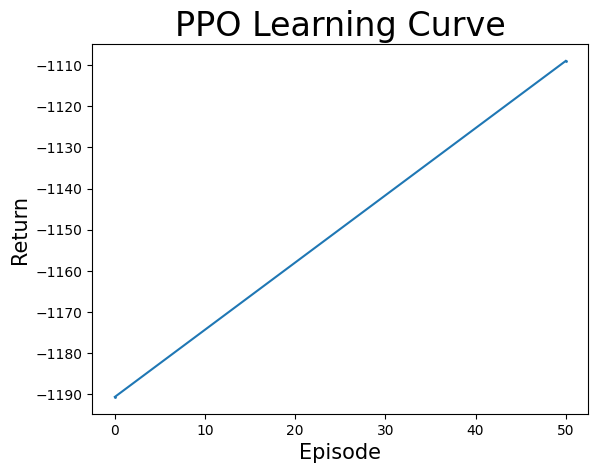

In [33]:
# Define parameter values
#env_name = 'CartPole-v1' # environment name
env_name = 'Pendulum-v1' # environment name
# env_name = "MountainCarContinuous-v0"

# For discretization of the action space
discretized_continuous_action_space = False
n_actions = 21 # number of actions to discretize the continuous action space

num_train_ite = 2000 # number of training iterations
num_seeds = 1 # fit model with 3 different seeds and plot average performance of 3 seeds
num_epochs = 10 # how many times we iterate the entire training dataset passing through the training
eval_freq = 50 # run evaluation of policy at each eval_freq trials
eval_epi_index = num_train_ite//eval_freq # use to create x label for plot
returns = np.zeros((num_seeds, eval_epi_index))
gamma = 0.999 # discount factor
lamda = 0.95 # GAE hyperparameter
clip_val = 0.2 # hyperparameter epsilon in clip objective
entropy_coef = 0.005 # hyperparameter entropy coefficient 
vf_coef = 0 # hyperparameter value function coefficient
policy_lr = 1e-4 # policy network's learning rate 
baseline_lr = 5e-4 # value network's learning rate

# Create the environment.
env = gym.make(env_name)

# setup the transformation for the actions in the discretized case
actions_transform = None
if discretized_continuous_action_space:
    action_range = (env.action_space.low[0], env.action_space.high[0])
    actions_transform = np.linspace(action_range[0], action_range[1], n_actions)

#detect if the environment is discrete or continuous
if isinstance(env.action_space, gym.spaces.Discrete):
    nA = env.action_space.n
else:
    if discretized_continuous_action_space:
        nA = n_actions
    else:
        nA = env.action_space.shape[0]

# detect if the environment state is discrete or continuous
if isinstance(env.observation_space, gym.spaces.Discrete):
    nS = env.observation_space.n
else:
    nS = env.observation_space.shape[0]

epoch_times = np.zeros((num_seeds, num_train_ite))
final_policy_nets = []
for i in tqdm.tqdm(range(num_seeds)):
    reward_means = []

    # Set random seed
    seed = np.random.randint(0, 1000)
    torch.manual_seed(seed)

    # Define policy and value networks
    if isinstance(env.action_space, gym.spaces.Discrete) or discretized_continuous_action_space:
        policy_net = NeuralNet(nS, nA, torch.nn.Softmax())
    else:
        #policy_net = NeuralNet(nS, nA, torch.nn.Identity())
        policy_net = ContinuousActor(nS, nA)
    policy_net_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)
    value_net = NeuralNet(nS, 1, torch.nn.ReLU())
    value_net_optimizer = optim.Adam(value_net.parameters(), lr=baseline_lr)

    # values to make iteration time plot
    epoch_start_time = 0 
    epoch_end_time = 0 

    for m in range(num_train_ite):
        epoch_start_time = time.time()
        # Train networks with PPO
        policy_net, value_net = train_PPO(env, policy_net, policy_net_optimizer, 
                                          value_net, value_net_optimizer, num_epochs, 
                                          clip_val=clip_val, gamma=gamma,
                                          entropy_coef=entropy_coef, lamda=lamda,
                                          vf_coef=vf_coef,
                                          nS=nS, nA=nA, 
                                          discretized_continuous_action_space=discretized_continuous_action_space, 
                                          actions_transform=actions_transform)
        
        epoch_end_time = time.time()
        epoch_times[i][m] = epoch_end_time - epoch_start_time # time taken for each epoch
        
        if m % eval_freq == 0:
            print("Episode: {}".format(m))
            G = np.zeros(20)
            for k in range(20):
                g = evaluate_policy(env, policy_net, nS=nS, nA=nA, 
                                    discretized_continuous_action_space=discretized_continuous_action_space, 
                                    actions_transform=actions_transform)
                G[k] = g

            reward_mean = G.mean()
            reward_sd = G.std()
            print("The avg. test reward for episode {0} is {1} with std of {2}.".format(m, reward_mean, reward_sd))
            reward_means.append(reward_mean)

    returns[i] = np.array(reward_means)
    final_policy_nets.append(policy_net)

# save the policy network
torch.save(policy_net.state_dict(), f"PPO_pendulum_continuous_policy_net.pt")


# Plot the performance over iterations
x = np.arange(eval_epi_index)*eval_freq
avg_returns = np.mean(returns, axis=0)
max_returns = np.max(returns, axis=0)
min_returns = np.min(returns, axis=0)

plt.fill_between(x, min_returns, max_returns, alpha=0.1)
plt.plot(x, avg_returns, '-o', markersize=1)

plt.xlabel('Episode', fontsize = 15)
plt.ylabel('Return', fontsize = 15)

plt.title("PPO Learning Curve", fontsize = 24)
plt.show()



50


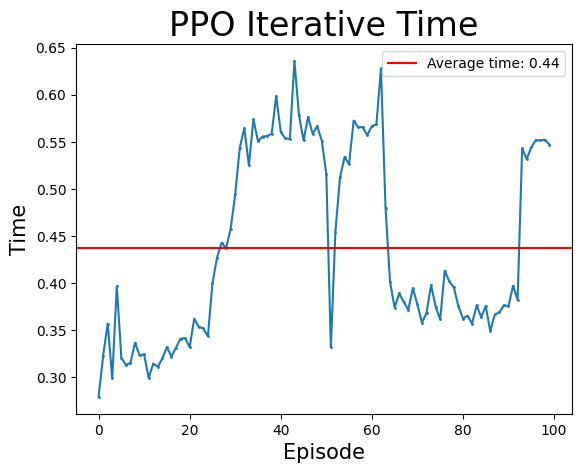

In [34]:
x = list(range(len(epoch_times[0])))
avg_epoch_times = np.mean(epoch_times, axis=0)
max_epoch_times = np.max(epoch_times, axis=0)
min_epoch_times = np.min(epoch_times, axis=0)

plt.fill_between(x, min_epoch_times, max_epoch_times, alpha=0.1)
plt.plot(x, avg_epoch_times, '-o', markersize=1)

#add average epoch time over the whole training
avr_epoch_time = np.mean(epoch_times)
plt.axhline(y=avr_epoch_time, color='r', linestyle='-', label=f'Average time: {avr_epoch_time:.2f}')
plt.legend() # add legend to the plot

plt.xlabel('Episode', fontsize = 15)
plt.ylabel('Time', fontsize = 15)

plt.title("PPO Iterative Time", fontsize = 24)

plt.savefig(f"PPO_{env_name}_time_per_epoch.png")

**Visualizing Pendulum continuous**

In [35]:
import time
#create an environment to test and visualize the policy
# env_name = 'CartPole-v1' # environment name
env_name = 'Pendulum-v1' # environment name
# env_name = 'MountainCar-v0' # environment name

env = gym.make(env_name, render_mode='human')

discretized_continuous_action_space = False
n_actions = 21

actions_transform = None
if discretized_continuous_action_space:
    action_range = (env.action_space.low[0], env.action_space.high[0])
    actions_transform = np.linspace(action_range[0], action_range[1], n_actions)

#detect if the environment is discrete or continuous
if isinstance(env.action_space, gym.spaces.Discrete):
    nS = env.observation_space.shape[0]
    nA = env.action_space.n
    policy_net = NeuralNet(nS, nA, torch.nn.Softmax())
else:
    if discretized_continuous_action_space:
        nA = n_actions
        nS = env.observation_space.shape[0]
        policy_net = NeuralNet(nS, nA, torch.nn.Softmax())
    else:
        nS = env.observation_space.shape[0]
        nA = env.action_space.shape[0]
        policy_net = ContinuousActor(nS, nA)

# load the policy network
policy_net.load_state_dict(torch.load(f"PPO_pendulum_continuous_policy_net.pt"))
# policy_net.eval()

episodes = 5
state, _ = env.reset()
if isinstance(env.action_space, gym.spaces.Discrete):
    state = torch.from_numpy(state).float().unsqueeze(0)
else:
    state = env.reset()[0]
rewards = []
for i in range(episodes):
    rewards.append(evaluate_policy(env, policy_net, nS=nS, nA=nA, discretized_continuous_action_space=discretized_continuous_action_space, actions_transform=actions_transform))
    print(f"Episode {i}: {rewards[-1]}")
    env.reset()
print(f"Average reward: {np.mean(rewards)} over {episodes} episodes")
env.close()
    

Episode 0: -887.3441397011438
Episode 1: -1315.657113336566
Episode 2: -1015.6738367772426
Episode 3: -1226.1078752430926
Episode 4: -1279.7283222764156
Average reward: -1144.902257466892 over 5 episodes


**Training Pendulum (discretized)**

  0%|          | 0/1 [00:00<?, ?it/s]c:\anaconda\envs\Rlearn\Lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Episode: 0
The avg. test reward for episode 0 is -1375.9726792138606 with std of 276.61392871822187.
Episode: 50
The avg. test reward for episode 50 is -1123.4862792057438 with std of 299.76528561413403.


100%|██████████| 1/1 [00:33<00:00, 33.43s/it]


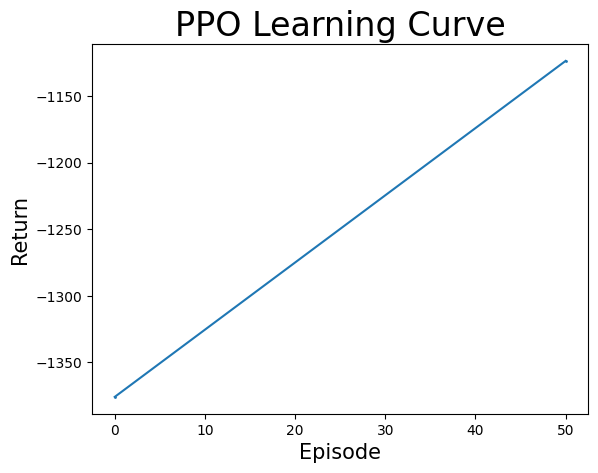

In [36]:
# Define parameter values
#env_name = 'CartPole-v1' # environment name
env_name = 'Pendulum-v1' # environment name
# env_name = "MountainCarContinuous-v0"

# For discretization of the action space
discretized_continuous_action_space = True
n_actions = 21 # number of actions to discretize the continuous action space

num_train_ite = 2000 # number of training iterations
num_seeds = 1 # fit model with 3 different seeds and plot average performance of 3 seeds
num_epochs = 10 # how many times we iterate the entire training dataset passing through the training
eval_freq = 50 # run evaluation of policy at each eval_freq trials
eval_epi_index = num_train_ite//eval_freq # use to create x label for plot
returns = np.zeros((num_seeds, eval_epi_index))
gamma = 0.999 # discount factor
lamda = 0.95 # GAE hyperparameter
clip_val = 0.2 # hyperparameter epsilon in clip objective
entropy_coef = 0.005 # hyperparameter entropy coefficient 
vf_coef = 0 # hyperparameter value function coefficient
policy_lr = 1e-4 # policy network's learning rate 
baseline_lr = 5e-4 # value network's learning rate

# Create the environment.
env = gym.make(env_name)

# setup the transformation for the actions in the discretized case
actions_transform = None
if discretized_continuous_action_space:
    action_range = (env.action_space.low[0], env.action_space.high[0])
    actions_transform = np.linspace(action_range[0], action_range[1], n_actions)

#detect if the environment is discrete or continuous
if isinstance(env.action_space, gym.spaces.Discrete):
    nA = env.action_space.n
else:
    if discretized_continuous_action_space:
        nA = n_actions
    else:
        nA = env.action_space.shape[0]

# detect if the environment state is discrete or continuous
if isinstance(env.observation_space, gym.spaces.Discrete):
    nS = env.observation_space.n
else:
    nS = env.observation_space.shape[0]

epoch_times = np.zeros((num_seeds, num_train_ite))
final_policy_nets = []
for i in tqdm.tqdm(range(num_seeds)):
    reward_means = []

    # Set random seed
    seed = np.random.randint(0, 1000)
    torch.manual_seed(seed)

    # Define policy and value networks
    if isinstance(env.action_space, gym.spaces.Discrete) or discretized_continuous_action_space:
        policy_net = NeuralNet(nS, nA, torch.nn.Softmax())
    else:
        #policy_net = NeuralNet(nS, nA, torch.nn.Identity())
        policy_net = ContinuousActor(nS, nA)
    policy_net_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)
    value_net = NeuralNet(nS, 1, torch.nn.ReLU())
    value_net_optimizer = optim.Adam(value_net.parameters(), lr=baseline_lr)

    # values to make iteration time plot
    epoch_start_time = 0 
    epoch_end_time = 0 

    for m in range(num_train_ite):
        epoch_start_time = time.time()
        # Train networks with PPO
        policy_net, value_net = train_PPO(env, policy_net, policy_net_optimizer, 
                                          value_net, value_net_optimizer, num_epochs, 
                                          clip_val=clip_val, gamma=gamma,
                                          entropy_coef=entropy_coef, lamda=lamda,
                                          vf_coef=vf_coef,
                                          nS=nS, nA=nA, 
                                          discretized_continuous_action_space=discretized_continuous_action_space, 
                                          actions_transform=actions_transform)
        
        epoch_end_time = time.time()
        epoch_times[i][m] = epoch_end_time - epoch_start_time # time taken for each epoch
        
        if m % eval_freq == 0:
            print("Episode: {}".format(m))
            G = np.zeros(20)
            for k in range(20):
                g = evaluate_policy(env, policy_net, nS=nS, nA=nA, 
                                    discretized_continuous_action_space=discretized_continuous_action_space, 
                                    actions_transform=actions_transform)
                G[k] = g

            reward_mean = G.mean()
            reward_sd = G.std()
            print("The avg. test reward for episode {0} is {1} with std of {2}.".format(m, reward_mean, reward_sd))
            reward_means.append(reward_mean)

    returns[i] = np.array(reward_means)
    final_policy_nets.append(policy_net)

# save the policy network
torch.save(policy_net.state_dict(), f"PPO_pendulum_discretized_policy_net.pt")


# Plot the performance over iterations
x = np.arange(eval_epi_index)*eval_freq
avg_returns = np.mean(returns, axis=0)
max_returns = np.max(returns, axis=0)
min_returns = np.min(returns, axis=0)

plt.fill_between(x, min_returns, max_returns, alpha=0.1)
plt.plot(x, avg_returns, '-o', markersize=1)

plt.xlabel('Episode', fontsize = 15)
plt.ylabel('Return', fontsize = 15)

plt.title("PPO Learning Curve", fontsize = 24)
plt.show()



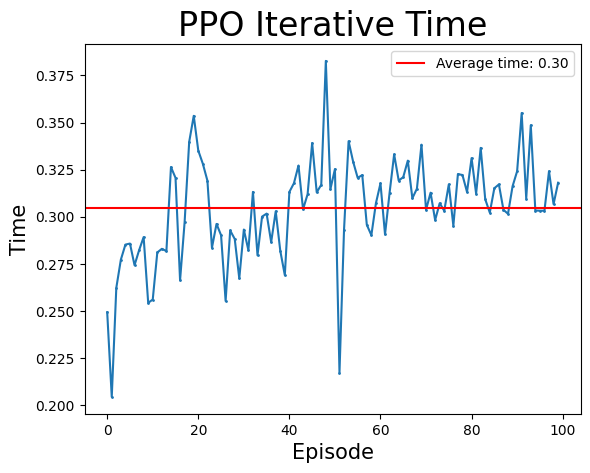

In [37]:
x = list(range(len(epoch_times[0])))
avg_epoch_times = np.mean(epoch_times, axis=0)
max_epoch_times = np.max(epoch_times, axis=0)
min_epoch_times = np.min(epoch_times, axis=0)

plt.fill_between(x, min_epoch_times, max_epoch_times, alpha=0.1)
plt.plot(x, avg_epoch_times, '-o', markersize=1)

#add average epoch time over the whole training
avr_epoch_time = np.mean(epoch_times)
plt.axhline(y=avr_epoch_time, color='r', linestyle='-', label=f'Average time: {avr_epoch_time:.2f}')
plt.legend() # add legend to the plot

plt.xlabel('Episode', fontsize = 15)
plt.ylabel('Time', fontsize = 15)

plt.title("PPO Iterative Time", fontsize = 24)

plt.savefig(f"PPO_{env_name}_time_per_epoch.png")

**Visualizing Pendulum discretized**

In [38]:
import time
#create an environment to test and visualize the policy
# env_name = 'CartPole-v1' # environment name
env_name = 'Pendulum-v1' # environment name
# env_name = 'MountainCar-v0' # environment name

env = gym.make(env_name, render_mode='human')

discretized_continuous_action_space = True
n_actions = 21

actions_transform = None
if discretized_continuous_action_space:
    action_range = (env.action_space.low[0], env.action_space.high[0])
    actions_transform = np.linspace(action_range[0], action_range[1], n_actions)

#detect if the environment is discrete or continuous
if isinstance(env.action_space, gym.spaces.Discrete):
    nS = env.observation_space.shape[0]
    nA = env.action_space.n
    policy_net = NeuralNet(nS, nA, torch.nn.Softmax())
else:
    if discretized_continuous_action_space:
        nA = n_actions
        nS = env.observation_space.shape[0]
        policy_net = NeuralNet(nS, nA, torch.nn.Softmax())
    else:
        nS = env.observation_space.shape[0]
        nA = env.action_space.shape[0]
        policy_net = ContinuousActor(nS, nA)

# load the policy network
policy_net.load_state_dict(torch.load(f"PPO_pendulum_discretized_policy_net.pt"))
# policy_net.eval()

episodes = 5
state, _ = env.reset()
if isinstance(env.action_space, gym.spaces.Discrete):
    state = torch.from_numpy(state).float().unsqueeze(0)
else:
    state = env.reset()[0]
rewards = []
for i in range(episodes):
    rewards.append(evaluate_policy(env, policy_net, nS=nS, nA=nA, discretized_continuous_action_space=discretized_continuous_action_space, actions_transform=actions_transform))
    print(f"Episode {i}: {rewards[-1]}")
    env.reset()
print(f"Average reward: {np.mean(rewards)} over {episodes} episodes")
env.close()
    

Episode 0: -1584.662776381536
Episode 1: -1694.129692774746
Episode 2: -916.4542794400379
Episode 3: -1754.7404887819928
Episode 4: -1528.4582812831507
Average reward: -1495.6891037322926 over 5 episodes


**Training CartPole (discrete)**

  0%|          | 0/1 [00:00<?, ?it/s]

Episode: 0
The avg. test reward for episode 0 is 25.45 with std of 12.220781480740092.
Episode: 50
The avg. test reward for episode 50 is 20.8 with std of 9.410632284814872.


100%|██████████| 1/1 [00:06<00:00,  6.54s/it]


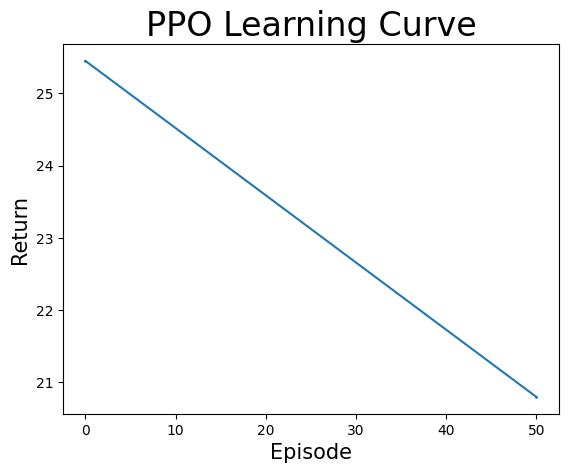

In [39]:
# Define parameter values
env_name = 'CartPole-v1' # environment name
#env_name = 'Pendulum-v1' # environment name
# env_name = "MountainCarContinuous-v0"

# For discretization of the action space
discretized_continuous_action_space = False
n_actions = 21 # number of actions to discretize the continuous action space

num_train_ite = 2000 # number of training iterations
num_seeds = 1 # fit model with 3 different seeds and plot average performance of 3 seeds
num_epochs = 10 # how many times we iterate the entire training dataset passing through the training
eval_freq = 50 # run evaluation of policy at each eval_freq trials
eval_epi_index = num_train_ite//eval_freq # use to create x label for plot
returns = np.zeros((num_seeds, eval_epi_index))
gamma = 0.999 # discount factor
lamda = 0.95 # GAE hyperparameter
clip_val = 0.2 # hyperparameter epsilon in clip objective
entropy_coef = 0.005 # hyperparameter entropy coefficient 
vf_coef = 0 # hyperparameter value function coefficient
policy_lr = 1e-4 # policy network's learning rate 
baseline_lr = 5e-4 # value network's learning rate

# Create the environment.
env = gym.make(env_name)

# setup the transformation for the actions in the discretized case
actions_transform = None
if discretized_continuous_action_space:
    action_range = (env.action_space.low[0], env.action_space.high[0])
    actions_transform = np.linspace(action_range[0], action_range[1], n_actions)

#detect if the environment is discrete or continuous
if isinstance(env.action_space, gym.spaces.Discrete):
    nA = env.action_space.n
else:
    if discretized_continuous_action_space:
        nA = n_actions
    else:
        nA = env.action_space.shape[0]

# detect if the environment state is discrete or continuous
if isinstance(env.observation_space, gym.spaces.Discrete):
    nS = env.observation_space.n
else:
    nS = env.observation_space.shape[0]

epoch_times = np.zeros((num_seeds, num_train_ite))
final_policy_nets = []
for i in tqdm.tqdm(range(num_seeds)):
    reward_means = []

    # Set random seed
    seed = np.random.randint(0, 1000)
    torch.manual_seed(seed)

    # Define policy and value networks
    if isinstance(env.action_space, gym.spaces.Discrete) or discretized_continuous_action_space:
        policy_net = NeuralNet(nS, nA, torch.nn.Softmax())
    else:
        #policy_net = NeuralNet(nS, nA, torch.nn.Identity())
        policy_net = ContinuousActor(nS, nA)
    policy_net_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)
    value_net = NeuralNet(nS, 1, torch.nn.ReLU())
    value_net_optimizer = optim.Adam(value_net.parameters(), lr=baseline_lr)

    # values to make iteration time plot
    epoch_start_time = 0 
    epoch_end_time = 0 

    for m in range(num_train_ite):
        epoch_start_time = time.time()
        # Train networks with PPO
        policy_net, value_net = train_PPO(env, policy_net, policy_net_optimizer, 
                                          value_net, value_net_optimizer, num_epochs, 
                                          clip_val=clip_val, gamma=gamma,
                                          entropy_coef=entropy_coef, lamda=lamda,
                                          vf_coef=vf_coef,
                                          nS=nS, nA=nA, 
                                          discretized_continuous_action_space=discretized_continuous_action_space, 
                                          actions_transform=actions_transform)
        
        epoch_end_time = time.time()
        epoch_times[i][m] = epoch_end_time - epoch_start_time # time taken for each epoch
        
        if m % eval_freq == 0:
            print("Episode: {}".format(m))
            G = np.zeros(20)
            for k in range(20):
                g = evaluate_policy(env, policy_net, nS=nS, nA=nA, 
                                    discretized_continuous_action_space=discretized_continuous_action_space, 
                                    actions_transform=actions_transform)
                G[k] = g

            reward_mean = G.mean()
            reward_sd = G.std()
            print("The avg. test reward for episode {0} is {1} with std of {2}.".format(m, reward_mean, reward_sd))
            reward_means.append(reward_mean)

    returns[i] = np.array(reward_means)
    final_policy_nets.append(policy_net)

# save the policy network
torch.save(policy_net.state_dict(), f"PPO_cartpole_discrete_policy_net.pt")


# Plot the performance over iterations
x = np.arange(eval_epi_index)*eval_freq
avg_returns = np.mean(returns, axis=0)
max_returns = np.max(returns, axis=0)
min_returns = np.min(returns, axis=0)

plt.fill_between(x, min_returns, max_returns, alpha=0.1)
plt.plot(x, avg_returns, '-o', markersize=1)

plt.xlabel('Episode', fontsize = 15)
plt.ylabel('Return', fontsize = 15)

plt.title("PPO Learning Curve", fontsize = 24)
plt.show()



50


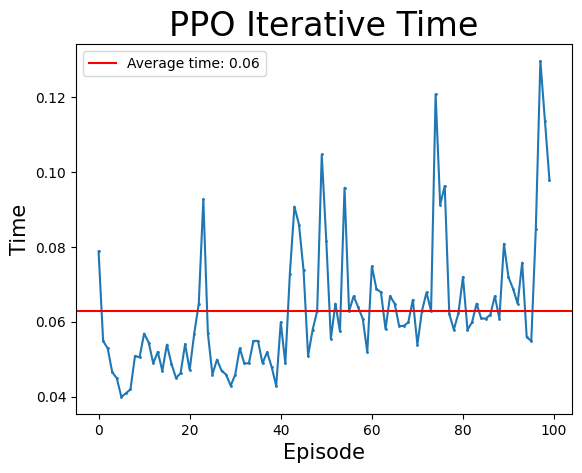

In [40]:
x = list(range(len(epoch_times[0])))
print(eval_freq)
avg_epoch_times = np.mean(epoch_times, axis=0)
max_epoch_times = np.max(epoch_times, axis=0)
min_epoch_times = np.min(epoch_times, axis=0)

plt.fill_between(x, min_epoch_times, max_epoch_times, alpha=0.1)
plt.plot(x, avg_epoch_times, '-o', markersize=1)

#add average epoch time over the whole training
avr_epoch_time = np.mean(epoch_times)
plt.axhline(y=avr_epoch_time, color='r', linestyle='-', label=f'Average time: {avr_epoch_time:.2f}')
plt.legend() # add legend to the plot

plt.xlabel('Episode', fontsize = 15)
plt.ylabel('Time', fontsize = 15)

plt.title("PPO Iterative Time", fontsize = 24)

plt.savefig(f"PPO_{env_name}_time_per_epoch.png")

**Visualizing CartPole**

In [41]:
import time
#create an environment to test and visualize the policy
env_name = 'CartPole-v1' # environment name
#env_name = 'Pendulum-v1' # environment name
# env_name = 'MountainCar-v0' # environment name

env = gym.make(env_name, render_mode='human')

discretized_continuous_action_space = False
n_actions = 21

actions_transform = None
if discretized_continuous_action_space:
    action_range = (env.action_space.low[0], env.action_space.high[0])
    actions_transform = np.linspace(action_range[0], action_range[1], n_actions)

#detect if the environment is discrete or continuous
if isinstance(env.action_space, gym.spaces.Discrete):
    nS = env.observation_space.shape[0]
    nA = env.action_space.n
    policy_net = NeuralNet(nS, nA, torch.nn.Softmax())
else:
    if discretized_continuous_action_space:
        nA = n_actions
        nS = env.observation_space.shape[0]
        policy_net = NeuralNet(nS, nA, torch.nn.Softmax())
    else:
        nS = env.observation_space.shape[0]
        nA = env.action_space.shape[0]
        policy_net = ContinuousActor(nS, nA)

# load the policy network
policy_net.load_state_dict(torch.load(f"PPO_cartpole_discrete_policy_net.pt"))
# policy_net.eval()

episodes = 5
state, _ = env.reset()
if isinstance(env.action_space, gym.spaces.Discrete):
    state = torch.from_numpy(state).float().unsqueeze(0)
else:
    state = env.reset()[0]
rewards = []
for i in range(episodes):
    rewards.append(evaluate_policy(env, policy_net, nS=nS, nA=nA, discretized_continuous_action_space=discretized_continuous_action_space, actions_transform=actions_transform))
    print(f"Episode {i}: {rewards[-1]}")
    env.reset()
print(f"Average reward: {np.mean(rewards)} over {episodes} episodes")
env.close()
    

Episode 0: 60.0
Episode 1: 25.0
Episode 2: 33.0
Episode 3: 21.0
Episode 4: 25.0
Average reward: 32.8 over 5 episodes
